# Tile Coding in TensorFlow

In this homework, I'm implementing simple tile coding approximation strategy with square tiles. I'm mostly drawing inspiration from the awesome code written by [@mohammadpz](https://github.com/mohammadpz/Theano_Tile_Coding). I figured it would be cool to have an implementation for TensorFlow as well. The code below also features some additional bells and whistles like batch processing of datasets and arbitrary displacement vectors for tilings (please refer to the book by *Sutton & Barto, 2017* page 213 for the details).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D

import utils

In [6]:
class TileCoder(object):
    def __init__(self, dims, min_coord, max_coord, num_tiles=6, num_tilings=4, displacement=None,
                 initializer=tf.constant_initializer(0.0), name="tile_coder"):
        self.name = name
        
        self.dims = dims
        self.min_coord = min_coord
        self.max_coord = max_coord
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        self.displacement = displacement
        
        self.tile_width = (self.max_coord - self.min_coord) / self.num_tiles
        self.shift_width = self.tile_width / self.num_tilings
        
        with tf.variable_scope(self.name):
            if self.displacement is None:
                self.displacement = tf.ones([1, self.dims])
            else:
                self.displacement = tf.convert_to_tensor(
                    self.displacement, dtype=tf.float32)
                self.displacement = tf.reshape(self.displacement, [1, self.dims])
                
        self._create_weights(initializer)
        
        
    def _create_weights(self, initializer):
        weights_shape = (self.num_tiles + 1,) * self.dims + (self.num_tilings,)
        with tf.variable_scope(self.name) as scope:
            self.weights = tf.get_variable(
                "weights", weights_shape, initializer=initializer)
            scope.reuse_variables()
    
    
    def _quantize(self, x):    
        r = tf.range(0, self.num_tilings, dtype=tf.float32)
        offsets = tf.expand_dims(r, -1) * self.displacement * self.shift_width
        offsets = tf.reshape(offsets, [1, self.num_tilings, self.dims])
        shifted_x = tf.expand_dims(x, 1) + offsets
        quantized_x = tf.cast(tf.floor_div(shifted_x, self.tile_width), dtype=tf.int32)
        
        return quantized_x
    
    
    def __call__(self, x):
        batch_size = x.get_shape().as_list()[0]
        
        quantized_x = self._quantize(x)
        
        # Add fictive coordinate that corresponds to the tiling index.
        r = tf.range(0, self.num_tilings, dtype=tf.int32)
        r = tf.reshape(r, [1, self.num_tilings, 1])
        r = tf.tile(r, [batch_size, 1, 1])
        quantized_x = tf.concat([quantized_x, r], axis=2)
        
        # Gather magic spell that I can cast only by trial and error.
        weights = tf.gather_nd(self.weights, quantized_x)
        value = tf.reduce_sum(weights, axis=1)
        
        return value
        

def tile_coder(x, min_coord, max_coord, num_tiles=6, num_tilings=4, displacement=None,
               initializer=tf.constant_initializer(0.0), name="tile_coder"):
    dims = x.get_shape().as_list()[1]
    tc = TileCoder(dims, min_coord, max_coord, num_tiles, num_tilings, displacement,
                   initializer, name)
    return tc(x)

In [7]:
NUM_TILINGS = 4
NUM_TILES = 6
DISPLACEMENT = np.ones(2)

NUM_SAMPLES = 10000
BATCH_SIZE = 10

def target_function(x):
    return np.sin(x[:, 0]) + np.cos(x[:, 1]) + 0.01 * np.random.randn()

dataset = utils.get_dataset(NUM_SAMPLES, 7, target_function)
min_coord = np.min(dataset["x"])
max_coord = np.max(dataset["x"])

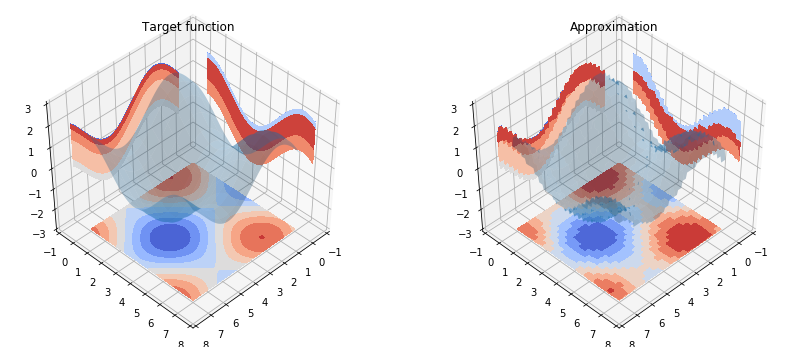

In [12]:
tf.reset_default_graph()

plt.close("all")
fig = plt.figure(figsize=np.array([14, 6]))
ax_0 = fig.add_subplot(1, 2, 1, projection='3d')
ax_1 = fig.add_subplot(1, 2, 2, projection='3d')

utils.plot_function(ax_0, target_function, 'Target function')

with tf.Session() as sess:
    x = tf.placeholder(dtype=tf.float32, shape=[BATCH_SIZE, dataset["x"].shape[1]])
    y = tf.placeholder(dtype=tf.float32, shape=[BATCH_SIZE])
    
    y_hat = tile_coder(x, min_coord, max_coord, num_tiles=NUM_TILES, num_tilings=NUM_TILINGS,
                       displacement=DISPLACEMENT, name="tile_coder")
    loss = tf.losses.mean_squared_error(predictions=y_hat, labels=y)
    
    opt = tf.train.GradientDescentOptimizer(0.1)
    coder_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="tile_coder")
    train_op = opt.minimize(loss, var_list=coder_weights)
    
    init_op = tf.global_variables_initializer()
    
    sess.run(init_op)
    
    for i in xrange(0, NUM_SAMPLES, BATCH_SIZE):
        x_batch = dataset["x"][i : i + BATCH_SIZE]
        y_batch = dataset["y"][i : i + BATCH_SIZE]
        
        sess.run(train_op, feed_dict={x: x_batch, y: y_batch})
        
    def get_approx(x_):
        num_samples = x_.shape[0]
        x_batch = np.zeros((BATCH_SIZE, x_.shape[1]))
        y_ = np.zeros(num_samples)
        for i in xrange(0, num_samples, BATCH_SIZE):
            chunk_size = BATCH_SIZE if i + BATCH_SIZE <= num_samples else num_samples - i
            x_batch[: chunk_size] = x_[i : i + chunk_size]
            y_hat_ = sess.run(y_hat, feed_dict={x: x_batch})
            y_[i : i + chunk_size] = y_hat_[: chunk_size]
        return y_
        
    Z = utils.plot_function(ax_1, get_approx, 'Approximation')
    
    plt.show()